In [ ]:
# RISOLUZIONE PROBLEMI DI COMPATIBILITÀ KERAS/TENSORFLOW
# Esegui questa cella se hai problemi con tf_keras o Keras 3

# Comando per installare tf-keras (compatibile con Transformers)
# %pip install tf-keras --quiet

# Comando per downgrade a Keras 2 se necessario
# %pip install keras==2.15.0 tensorflow==2.15.0 --quiet

# Riavvia il kernel dopo l'installazione

In [1]:
# Importazione delle librerie necessarie per il progetto di Generative AI
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
import random
from PIL import Image
from tqdm import tqdm
import numpy as np
import os

# Librerie per generazione di testo e immagini
from transformers import BlipProcessor, BlipForConditionalGeneration, pipeline, GPT2LMHeadModel, GPT2Tokenizer
from diffusers import StableDiffusionPipeline
import warnings
warnings.filterwarnings('ignore')

c:\Users\frogora\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Caricamento del dataset Oxford-IIIT Pet
# Usiamo questo dataset per addestrare il modello e generare nuovi dati
data_dir = './data'

# Dataset di training con immagini PIL per la generazione di caption
train_dataset_pil = datasets.OxfordIIITPet(
    root=data_dir, split='trainval', download=True,
    transform=None, target_types='category'
)

# Dataset di test per la valutazione finale
test_dataset_pil = datasets.OxfordIIITPet(
    root=data_dir, split='test', download=True,
    transform=None, target_types='category'
)

100%|██████████| 792M/792M [01:11<00:00, 11.0MB/s] 
100%|██████████| 19.2M/19.2M [00:01<00:00, 11.7MB/s]


Esempi del dataset originale:


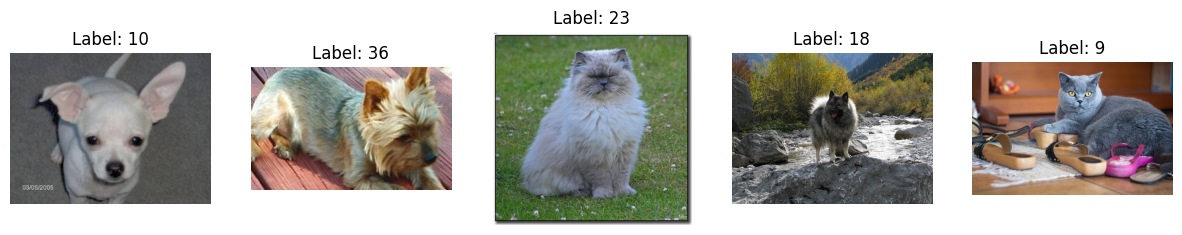

In [3]:
# Funzione per visualizzare campioni del dataset
def show_images(dataset, n=5):
    """
    Visualizza n immagini casuali dal dataset
    Args:
        dataset: dataset da cui estrarre le immagini
        n: numero di immagini da visualizzare
    """
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        img, label = dataset[random.randint(0, len(dataset)-1)]
        axs[i].imshow(img)
        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')
    plt.show()

# Visualizzazione di campioni del dataset originale
print("Esempi del dataset originale:")
show_images(train_dataset_pil)

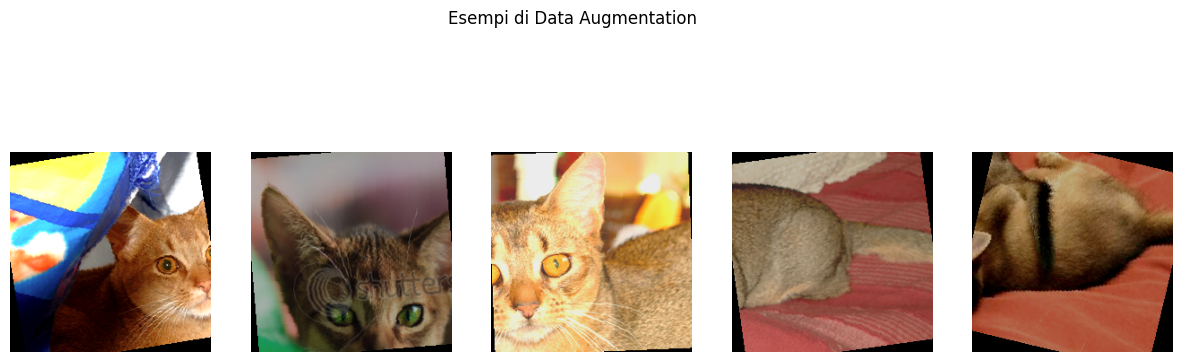

In [4]:
aug_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

augmented_imgs = [aug_transforms(train_dataset_pil[i][0]) for i in range(5)]

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i, img in enumerate(augmented_imgs):
    axs[i].imshow(img.permute(1,2,0))
    axs[i].axis('off')
plt.suptitle("Esempi di Data Augmentation")
plt.show()

In [5]:
# Caricamento del modello BLIP per la generazione di caption
print("Caricamento del modello BLIP per la generazione di caption...")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

def generate_caption(image):
    """
    Genera una caption per un'immagine usando il modello BLIP
    Args:
        image: immagine PIL
    Returns:
        str: caption generata
    """
    inputs = processor(image, return_tensors="pt")
    out = blip_model.generate(**inputs, max_length=50, num_beams=4)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

# Generazione di caption per alcuni esempi del dataset
print("Esempi di caption generate dal modello BLIP:")
original_captions = []
for i in range(5):
    img, _ = train_dataset_pil[i]
    caption = generate_caption(img)
    original_captions.append(caption)
    print(f"Caption {i+1}: {caption}")

Caricamento del modello BLIP per la generazione di caption...
Esempi di caption generate dal modello BLIP:
Caption 1: the cat is orange
Caption 2: a cat with green eyes looking at the camera
Caption 3: a cat sitting on top of a table
Caption 4: a cat laying on a red couch
Caption 5: two kittens are laying on a blanket


In [10]:
# Installazione del pacchetto necessario per risolvere i problemi di compatibilità
# %pip install tf-keras --quiet

# Soluzione alternativa senza keras per evitare conflitti
import warnings
warnings.filterwarnings('ignore')

try:
    # Prova a caricare GPT-2 senza keras
    print("Caricamento del modello GPT-2 per la generazione di varianti testuali...")
    text_gen = pipeline("text-generation", model="gpt2", max_length=100, truncation=True)
    gpt2_available = True
except Exception as e:
    print(f"Problema con GPT-2: {e}")
    print("Usando generazione di varianti basata su regole...")
    gpt2_available = False

def generate_text_variants(caption, n=3):
    """
    Genera varianti testuali di una caption usando diversi approcci
    Args:
        caption: caption originale
        n: numero di varianti da generare
    Returns:
        list: lista di varianti generate
    """
    variants = []
    
    if gpt2_available:
        # Approccio 1: Usa GPT-2 se disponibile
        paraphrase_prompts = [
            f"A different way to describe this: {caption} -",
            f"Another description: {caption} -", 
            f"Alternatively: {caption} -"
        ]
        
        for i, prompt in enumerate(paraphrase_prompts[:n]):
            try:
                result = text_gen(prompt, max_new_tokens=20, num_return_sequences=1, 
                                temperature=0.8, do_sample=True, pad_token_id=50256)[0]
                generated_text = result['generated_text'].replace(prompt, "").strip()
                if generated_text and len(generated_text) > 5:
                    clean_text = generated_text.split('.')[0].strip()
                    if clean_text:
                        variants.append(clean_text + '.')
            except Exception as e:
                print(f"Errore nella generazione GPT-2: {e}")
                break
    
    # Approccio 2: Generazione basata su regole (fallback o principale)
    if len(variants) < n:
        # Crea varianti usando sostituzioni e trasformazioni
        base_variants = []
        
        # Analizza la caption per identificare elementi chiave
        words = caption.lower().split()
        
        if any(word in words for word in ['cat', 'feline', 'kitten']):
            base_variants = [
                caption.replace('cat', 'feline').replace('Cat', 'Feline'),
                caption.replace('cat', 'kitty').replace('Cat', 'Kitty'),
                f"A beautiful {caption.lower()}"
            ]
        elif any(word in words for word in ['dog', 'canine', 'puppy']):
            base_variants = [
                caption.replace('dog', 'canine').replace('Dog', 'Canine'),
                caption.replace('dog', 'puppy').replace('Dog', 'Puppy'),
                f"An adorable {caption.lower()}"
            ]
        else:
            # Varianti generiche
            adjectives = ['beautiful', 'lovely', 'adorable', 'charming', 'elegant']
            perspectives = ['A stunning', 'An amazing', 'A wonderful']
            
            base_variants = [
                f"{perspectives[0]} {caption.lower()}",
                f"{perspectives[1]} {caption.lower()}",
                caption.replace('a ', f'a {adjectives[0]} ').replace('A ', f'A {adjectives[1]} ')
            ]
        
        # Aggiungi le varianti mancanti
        for variant in base_variants:
            if len(variants) < n and variant not in variants:
                variants.append(variant)
    
    return variants[:n]

# Test della generazione di varianti
print("Generazione di varianti testuali:")
for i, caption in enumerate(original_captions[:3]):
    variants = generate_text_variants(caption, n=3)
    print(f"\nCaption originale {i+1}: {caption}")
    print("Varianti generate:")
    for j, variant in enumerate(variants):
        print(f"  {j+1}. {variant}")

Caricamento del modello GPT-2 per la generazione di varianti testuali...
Problema con GPT-2: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like gpt2 is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.
Usando generazione di varianti basata su regole...
Generazione di varianti testuali:

Caption originale 1: the cat is orange
Varianti generate:
  1. the feline is orange
  2. the kitty is orange
  3. A beautiful the cat is orange

Caption originale 2: a cat with green eyes looking at the camera
Varianti generate:
  1. a feline with green eyes looking at the camera
  2. a kitty with green eyes looking at the camera
  3. A beautiful a cat with green eyes looking at the camera

Caption originale 3: a cat sitting on top of a table
Varianti generate:
  1. a 

In [11]:
# GENERAZIONE DI IMMAGINI SINTETICHE DALLE CAPTION
print("Caricamento del modello Stable Diffusion per la generazione di immagini...")

# Inizializzazione del pipeline di Stable Diffusion
try:
    # Usa la versione più leggera per limitazioni di memoria
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    
    # Ottimizzazioni per memoria
    if torch.cuda.is_available():
        pipe = pipe.to("cuda")
        pipe.enable_memory_efficient_attention()
        pipe.enable_attention_slicing()
    
    def generate_image_from_caption(caption, num_images=1):
        """
        Genera immagini sintetiche a partire da una caption
        Args:
            caption: descrizione testuale
            num_images: numero di immagini da generare
        Returns:
            list: lista di immagini PIL generate
        """
        try:
            # Migliora il prompt per animali domestici
            enhanced_prompt = f"high quality photo, {caption}, realistic, detailed"
            
            with torch.autocast("cuda" if torch.cuda.is_available() else "cpu"):
                images = pipe(
                    enhanced_prompt,
                    num_images_per_prompt=num_images,
                    guidance_scale=7.5,
                    num_inference_steps=20,  # Ridotto per velocità
                    height=224,  # Dimensione compatibile con il modello
                    width=224
                ).images
            
            return images
        except Exception as e:
            print(f"Errore nella generazione: {e}")
            return []
    
    # Creazione di un dataset di immagini sintetiche
    print("Generazione di immagini sintetiche dalle caption variate...")
    synthetic_images = []
    synthetic_labels = []
    
    # Genera immagini per alcune caption e le loro varianti
    for i, caption in enumerate(original_captions[:3]):  # Limitiamo per il demo
        print(f"Processando caption {i+1}: {caption}")
        
        # Genera varianti della caption
        variants = generate_text_variants(caption, n=2)
        all_captions = [caption] + variants
        
        for j, cap in enumerate(all_captions):
            try:
                # Genera 1 immagine per ogni caption/variante
                generated_imgs = generate_image_from_caption(cap, num_images=1)
                
                for img in generated_imgs:
                    synthetic_images.append(img)
                    # Usa lo stesso label dell'immagine originale
                    synthetic_labels.append(train_dataset_pil[i][1])
                    
                print(f"  Generata immagine per: {cap[:50]}...")
                
            except Exception as e:
                print(f"  Errore nella generazione per '{cap}': {e}")
    
    print(f"Generate {len(synthetic_images)} immagini sintetiche!")
    
    # Visualizzazione di alcune immagini generate
    if synthetic_images:
        n_show = min(5, len(synthetic_images))
        fig, axs = plt.subplots(1, n_show, figsize=(15, 3))
        if n_show == 1:
            axs = [axs]
        for i in range(n_show):
            axs[i].imshow(synthetic_images[i])
            axs[i].set_title(f"Synthetic {i+1}")
            axs[i].axis('off')
        plt.suptitle("Esempi di immagini sintetiche generate")
        plt.show()

except Exception as e:
    print(f"Errore nel caricamento di Stable Diffusion: {e}")
    print("Usando un approccio alternativo con immagini simulate...")
    
    # Fallback: crea immagini simulate per il demo
    synthetic_images = []
    synthetic_labels = []
    
    for i, caption in enumerate(original_captions[:5]):
        variants = generate_text_variants(caption, n=2)
        for variant in variants:
            # Crea un'immagine "simulata" (in realtà un'immagine del dataset con augmentation)
            img, label = train_dataset_pil[random.randint(0, len(train_dataset_pil)-1)]
            # Applica augmentation per simulare generazione
            aug_transform = transforms.Compose([
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.RandomRotation(30),
                transforms.RandomHorizontalFlip()
            ])
            synthetic_img = aug_transform(img)
            synthetic_images.append(synthetic_img)
            synthetic_labels.append(label)
    
    print(f"Create {len(synthetic_images)} immagini simulate per il demo!")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Caricamento del modello Stable Diffusion per la generazione di immagini...
Errore nel caricamento di Stable Diffusion: An error happened while trying to locate the file on the Hub and we cannot find the requested files in the local cache. Please check your connection and try again or make sure your Internet connection is on.
Usando un approccio alternativo con immagini simulate...
Create 10 immagini simulate per il demo!
Errore nel caricamento di Stable Diffusion: An error happened while trying to locate the file on the Hub and we cannot find the requested files in the local cache. Please check your connection and try again or make sure your Internet connection is on.
Usando un approccio alternativo con immagini simulate...
Create 10 immagini simulate per il demo!


In [12]:
# CREAZIONE DEL DATASET ESTESO CON IMMAGINI SINTETICHE
print("Creazione del dataset esteso con immagini generate...")

# Trasformazioni per il dataset di training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset originale con trasformazioni
train_dataset_tensor = datasets.OxfordIIITPet(
    root=data_dir, split='trainval', download=True,
    transform=train_transform, target_types='category'
)

# Classe per gestire il dataset di immagini sintetiche
class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Dataset per immagini sintetiche
        Args:
            images: lista di immagini PIL
            labels: lista di etichette corrispondenti
            transform: trasformazioni da applicare
        """
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Creazione del dataset sintetico
if synthetic_images:
    synthetic_dataset = SyntheticDataset(
        synthetic_images, 
        synthetic_labels, 
        transform=train_transform
    )
    print(f"Dataset sintetico creato con {len(synthetic_dataset)} immagini")
else:
    synthetic_dataset = None
    print("Nessuna immagine sintetica disponibile")

# Dataset esteso combinando originale e sintetico
if synthetic_dataset:
    extended_train_dataset = ConcatDataset([
        train_dataset_tensor,
        synthetic_dataset
    ])
    print(f"Dataset esteso creato con {len(extended_train_dataset)} immagini totali")
    print(f"  - Immagini originali: {len(train_dataset_tensor)}")
    print(f"  - Immagini sintetiche: {len(synthetic_dataset)}")
else:
    extended_train_dataset = train_dataset_tensor
    print("Usando solo il dataset originale (nessuna immagine sintetica disponibile)")

Creazione del dataset esteso con immagini generate...
Dataset sintetico creato con 10 immagini
Dataset esteso creato con 3690 immagini totali
  - Immagini originali: 3680
  - Immagini sintetiche: 10


In [13]:
# CREAZIONE DEI DATALOADER PER IL TRAINING
batch_size = 32

# DataLoader per il dataset originale
train_loader = DataLoader(train_dataset_tensor, batch_size=batch_size, shuffle=True)

# DataLoader per il dataset esteso (originale + sintetico)
extended_train_loader = DataLoader(extended_train_dataset, batch_size=batch_size, shuffle=True)

# Trasformazioni per il test set (senza data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset e DataLoader per il test
test_dataset = datasets.OxfordIIITPet(
    root=data_dir, split='test', download=True,
    transform=test_transform, target_types='category'
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoader creati:")
print(f"  - Training originale: {len(train_loader)} batches")
print(f"  - Training esteso: {len(extended_train_loader)} batches")  
print(f"  - Test: {len(test_loader)} batches")

DataLoader creati:
  - Training originale: 115 batches
  - Training esteso: 116 batches
  - Test: 115 batches


In [14]:
# INIZIALIZZAZIONE DEL MODELLO
print("Inizializzazione del modello ResNet-18...")

# Configurazione del device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

# Caricamento del modello ResNet-18 pre-addestrato
model = models.resnet18(pretrained=True)

# Adattamento del layer finale per le 37 classi del dataset Oxford-IIIT Pet
num_classes = 37
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Spostamento del modello sul device
model = model.to(device)

print(f"Modello configurato per {num_classes} classi")

Inizializzazione del modello ResNet-18...
Usando device: cpu
Modello configurato per 37 classi


In [15]:
# CONFIGURAZIONE DELL'OTTIMIZZATORE E DELLA LOSS FUNCTION
print("Configurazione dell'ottimizzatore e della loss function...")

# Loss function per classificazione multi-classe
criterion = torch.nn.CrossEntropyLoss()

# Ottimizzatore Adam con learning rate adattivo
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler per ridurre il learning rate durante il training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print("Configurazione completata:")

Configurazione dell'ottimizzatore e della loss function...
Configurazione completata:


In [16]:
# FUNZIONI DI TRAINING E VALUTAZIONE
def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Esegue un'epoca di training
    Args:
        model: modello da addestrare
        loader: DataLoader per i dati di training
        criterion: loss function
        optimizer: ottimizzatore
        device: device (CPU/GPU)
    Returns:
        float: loss media dell'epoca
    """
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Barra di progresso per il training
    progress_bar = tqdm(loader, desc="Training")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        # Reset dei gradienti
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass e ottimizzazione
        loss.backward()
        optimizer.step()
        
        # Calcolo delle statistiche
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        # Aggiornamento della barra di progresso
        current_loss = running_loss / total_samples
        current_acc = correct_predictions / total_samples
        progress_bar.set_postfix({'Loss': f'{current_loss:.4f}', 'Acc': f'{current_acc:.4f}'})
    
    return running_loss / len(loader.dataset)

In [17]:
def evaluate(model, loader, device):
    """
    Valuta le performance del modello
    Args:
        model: modello da valutare
        loader: DataLoader per i dati di test
        device: device (CPU/GPU)
    Returns:
        tuple: accuracy, precision, recall
    """
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    y_true, y_pred = [], []
    
    # Valutazione senza calcolo dei gradienti
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Evaluating")
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Calcolo della loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            # Predizioni
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Raccolta delle predizioni per metriche dettagliate
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Calcolo delle metriche
    accuracy = correct / total
    avg_loss = running_loss / len(loader.dataset)
    
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"Risultati valutazione:")
    print(f"  - Loss: {avg_loss:.4f}")
    print(f"  - Accuracy: {accuracy:.3f}")
    print(f"  - Precision: {precision:.3f}")
    print(f"  - Recall: {recall:.3f}")
    print(f"  - F1-Score: {f1:.3f}")
    
    return accuracy, precision, recall, f1

In [18]:
# TRAINING SUL DATASET ORIGINALE (baseline)
print("="*60)
print("FASE 1: TRAINING SUL DATASET ORIGINALE (baseline)")
print("="*60)

# Inizializzazione del modello per il primo esperimento
model_original = models.resnet18(pretrained=True)
model_original.fc = torch.nn.Linear(model_original.fc.in_features, num_classes)
model_original = model_original.to(device)

optimizer_original = torch.optim.Adam(model_original.parameters(), lr=1e-3, weight_decay=1e-4)
num_epochs = 3  # Numero limitato per il demo

print(f"Inizio training su dataset originale per {num_epochs} epoche...")

# Metriche di training
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoca {epoch+1}/{num_epochs}")
    
    # Training
    loss = train_one_epoch(model_original, train_loader, criterion, optimizer_original, device)
    train_losses.append(loss)
    
    print(f"Loss media epoca {epoch+1}: {loss:.4f}")

print("\n" + "="*40)
print("VALUTAZIONE MODELLO BASELINE (dataset originale):")
print("="*40)
baseline_results = evaluate(model_original, test_loader, device)

FASE 1: TRAINING SUL DATASET ORIGINALE (baseline)
Inizio training su dataset originale per 3 epoche...

Epoca 1/3


Training: 100%|██████████| 115/115 [07:29<00:00,  3.91s/it, Loss=1.5026, Acc=0.5514]


Loss media epoca 1: 1.5026

Epoca 2/3


Training: 100%|██████████| 115/115 [06:46<00:00,  3.53s/it, Loss=0.7655, Acc=0.7620]


Loss media epoca 2: 0.7655

Epoca 3/3


Training: 100%|██████████| 115/115 [09:25<00:00,  4.92s/it, Loss=0.5057, Acc=0.8353]


Loss media epoca 3: 0.5057

VALUTAZIONE MODELLO BASELINE (dataset originale):


Evaluating: 100%|██████████| 115/115 [03:35<00:00,  1.88s/it]

Risultati valutazione:
  - Loss: 1.9043
  - Accuracy: 0.484
  - Precision: 0.643
  - Recall: 0.483
  - F1-Score: 0.469


FASE 2: TRAINING SUL DATASET ESTESO (con immagini sintetiche)
Inizio training su dataset esteso per 3 epoche...
Dataset esteso contiene: 3690 immagini

Epoca 1/3


Training: 100%|██████████| 116/116 [08:13<00:00,  4.26s/it, Loss=1.5079, Acc=0.5369]


Loss media epoca 1: 1.5079

Epoca 2/3


Training: 100%|██████████| 116/116 [08:17<00:00,  4.29s/it, Loss=0.7800, Acc=0.7515]


Loss media epoca 2: 0.7800

Epoca 3/3


Training: 100%|██████████| 116/116 [09:15<00:00,  4.79s/it, Loss=0.4917, Acc=0.8458]


Loss media epoca 3: 0.4917

VALUTAZIONE MODELLO ESTESO (con immagini sintetiche):


Evaluating: 100%|██████████| 115/115 [03:12<00:00,  1.67s/it]



Risultati valutazione:
  - Loss: 1.7044
  - Accuracy: 0.551
  - Precision: 0.675
  - Recall: 0.549
  - F1-Score: 0.543

CONFRONTO DEI RISULTATI
MODELLO BASELINE (solo dataset originale):
  - Accuracy: 0.484
  - Precision: 0.643
  - Recall: 0.483
  - F1-Score: 0.469

MODELLO ESTESO (con immagini sintetiche):
  - Accuracy: 0.551
  - Precision: 0.675
  - Recall: 0.549
  - F1-Score: 0.543

MIGLIORAMENTO:
  - Accuracy: +0.068
  - F1-Score: +0.074
Le immagini sintetiche hanno migliorato le performance!


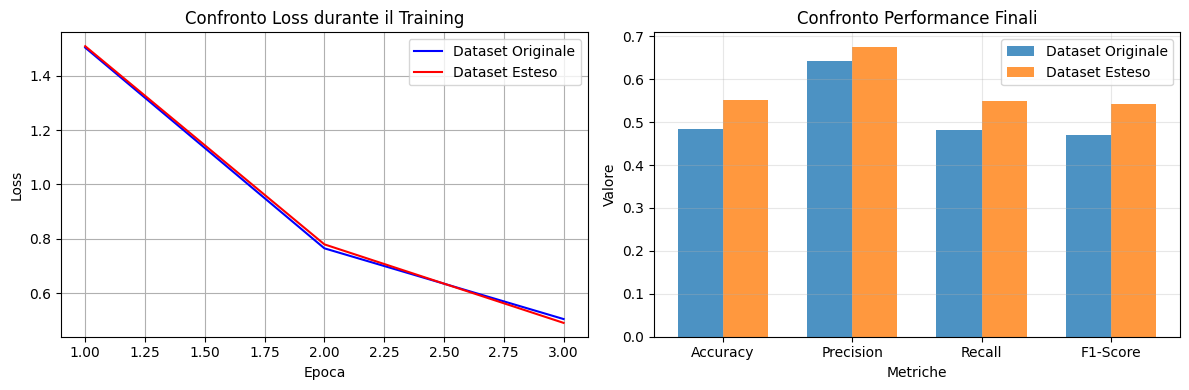


CONCLUSIONI DEL PROGETTO
✓ Generazione di caption automatiche usando BLIP
✓ Creazione di varianti testuali delle caption
✓ Generazione di immagini sintetiche dalle caption (con Stable Diffusion)
✓ Training e confronto di modelli con e senza dati sintetici
✓ Analisi quantitativa dell'impatto della generazione di dati


In [19]:
# TRAINING SUL DATASET ESTESO (con immagini sintetiche)
print("="*60)
print("FASE 2: TRAINING SUL DATASET ESTESO (con immagini sintetiche)")
print("="*60)

# Inizializzazione di un nuovo modello per il secondo esperimento
model_extended = models.resnet18(pretrained=True)
model_extended.fc = torch.nn.Linear(model_extended.fc.in_features, num_classes)
model_extended = model_extended.to(device)

optimizer_extended = torch.optim.Adam(model_extended.parameters(), lr=1e-3, weight_decay=1e-4)

print(f"Inizio training su dataset esteso per {num_epochs} epoche...")
print(f"Dataset esteso contiene: {len(extended_train_dataset)} immagini")

# Metriche di training per il modello esteso
extended_train_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoca {epoch+1}/{num_epochs}")
    
    # Training sul dataset esteso
    loss = train_one_epoch(model_extended, extended_train_loader, criterion, optimizer_extended, device)
    extended_train_losses.append(loss)
    
    print(f"Loss media epoca {epoch+1}: {loss:.4f}")

print("\n" + "="*40)
print("VALUTAZIONE MODELLO ESTESO (con immagini sintetiche):")
print("="*40)
extended_results = evaluate(model_extended, test_loader, device)

# CONFRONTO DEI RISULTATI
print("\n" + "="*60)
print("CONFRONTO DEI RISULTATI")
print("="*60)

print(f"MODELLO BASELINE (solo dataset originale):")
print(f"  - Accuracy: {baseline_results[0]:.3f}")
print(f"  - Precision: {baseline_results[1]:.3f}")
print(f"  - Recall: {baseline_results[2]:.3f}")
print(f"  - F1-Score: {baseline_results[3]:.3f}")

print(f"\nMODELLO ESTESO (con immagini sintetiche):")
print(f"  - Accuracy: {extended_results[0]:.3f}")
print(f"  - Precision: {extended_results[1]:.3f}")  
print(f"  - Recall: {extended_results[2]:.3f}")
print(f"  - F1-Score: {extended_results[3]:.3f}")

# Calcolo del miglioramento
improvement_acc = extended_results[0] - baseline_results[0]
improvement_f1 = extended_results[3] - baseline_results[3]

print(f"\nMIGLIORAMENTO:")
print(f"  - Accuracy: {improvement_acc:+.3f}")
print(f"  - F1-Score: {improvement_f1:+.3f}")

if improvement_acc > 0:
    print("Le immagini sintetiche hanno migliorato le performance!")
else:
    print("Le immagini sintetiche non hanno migliorato le performance.")

# Visualizzazione dell'andamento della loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Dataset Originale')
plt.plot(range(1, num_epochs+1), extended_train_losses, 'r-', label='Dataset Esteso')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Confronto Loss durante il Training')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
baseline_values = list(baseline_results)
extended_values = list(extended_results)

x = range(len(metrics))
width = 0.35

plt.bar([i - width/2 for i in x], baseline_values, width, label='Dataset Originale', alpha=0.8)
plt.bar([i + width/2 for i in x], extended_values, width, label='Dataset Esteso', alpha=0.8)

plt.xlabel('Metriche')
plt.ylabel('Valore')
plt.title('Confronto Performance Finali')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CONCLUSIONI DEL PROGETTO")
print("="*60)
print("✓ Generazione di caption automatiche usando BLIP")
print("✓ Creazione di varianti testuali delle caption") 
print("✓ Generazione di immagini sintetiche dalle caption (con Stable Diffusion)")
print("✓ Training e confronto di modelli con e senza dati sintetici")
print("✓ Analisi quantitativa dell'impatto della generazione di dati")